# Zhang 2023 Upper Bound Temperature
This looks at applying the theory from Byrne 2023 but to an aquaplanet.

Looks at how the hottest days compare to the theoretical upper bound temperature for a given the 500hPa temperature.

In [242]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn, frierson_atmospheric_heating
from isca_tools.utils.constants import kappa, epsilon, L_v, c_p, g, R_v, radius_earth
from isca_tools.utils import area_weight_mean_lat, area_weighting, annual_time_slice
from isca_tools.papers.miyawaki_2022 import get_dmse_dt, get_dvmse_dy, get_r1
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy.stats import percentileofscore
from scipy import interpolate

In [2]:
# Load dataset
exp_dir = 'tau_sweep/aquaplanet/'
# only keep variables required to compute relative humidity, MSE and miyawaki R1 value
var_keep = ['temp', 'sphum', 'vcomp', 'ucomp', 'omega', 'ps', 'height', 'precipitation']
tau_lw_ref = 1
exp_name = f"k={str(tau_lw_ref).replace('.','_')}"
ds = isca_tools.load_dataset(exp_dir + exp_name)
namelist = isca_tools.load_namelist(exp_dir + exp_name)  # Need this for albedo_value
albedo = namelist['mixed_layer_nml']['albedo_value']
tau_sw = namelist['two_stream_gray_rad_nml']['atm_abs']
tau_lw = namelist['two_stream_gray_rad_nml']['odp']

## Get datasets
Get one dataset, `ds_lat`, for each latitude bin containing surface and free troposphere data for that latitude range.

In [3]:
# Get data set averaged over all summer days considering in each latitude bin.
# Do this for each optical depth value
use_time_start = 360*2
pressure_ft = 500

ds_use = ds.sel(time=slice(use_time_start, np.inf), drop=True)[var_keep]
ds_use = ds_use.sel(pfull=[pressure_ft, np.inf], method='nearest', drop=True).load()
pressure_ft_actual = float(ds_use.pfull[0])        # actual free troposphere pressure in hPa
pressure_surface = float(ds_use.pfull[1])          # surface pressure in hPa

In [138]:
# Tropics
# region = 'tropics'
# lat_min = 0
# lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 30
# lat_max = 60
# Poles
region = 'High Latitudes'
lat_min = 70
lat_max = 90

### Figure 2 - Time series of annual hottest days
Below, I try to replicate Figure 2 in the paper. For each year in the simulation, I find the hottest day in each region (I actually get 2 values for each year - one in northern hemisphere and one in southern hemisphere, as the hemispheres are equivalent). For each of these days, I keep track of some variables in the 10 days preceeding and 10 days after the hottest day.

The plots then show these variables averaged over all years.

In [277]:
# Get all variables at surface and free troposphere on hottest day for each year considered
# Do separately for each hemisphere as should be indentical
n_years = int(len(ds_use.time)/360)         # multiply by 2 as each hemisphere is identical so get max from each
# Keep all variables in a (2*spatial_sz['lat']+1) x (2*spatial_sz['lon']+1) size grid centered on location of hottest day
spatial_sz = {'time':10, 'lat':10, 'lon':10}
n_year_days = 360       # number of days in a year
max_info = {'temp': np.zeros((n_years, 2, 2*spatial_sz['time']+1, 2*spatial_sz['lat']+1, 2*spatial_sz['lon']+1, ds_use.pfull.size)),
            'sphum': np.zeros((n_years, 2, 2*spatial_sz['time']+1, 2*spatial_sz['lat']+1, 2*spatial_sz['lon']+1)),
            'height': np.zeros((n_years, 2, 2*spatial_sz['time']+1, 2*spatial_sz['lat']+1, 2*spatial_sz['lon']+1, ds_use.pfull.size)),
            'precipitation': np.zeros((n_years, 2, 2*spatial_sz['time']+1, 2*spatial_sz['lat']+1, 2*spatial_sz['lon']+1)),
            'ps': np.zeros((n_years, 2, 2*spatial_sz['time']+1, 2*spatial_sz['lat']+1, 2*spatial_sz['lon']+1)),
            'ucomp': np.zeros((n_years, 2, 2*spatial_sz['time']+1, 2*spatial_sz['lat']+1, 2*spatial_sz['lon']+1, ds_use.pfull.size)),
            'vcomp': np.zeros((n_years, 2, 2*spatial_sz['time']+1, 2*spatial_sz['lat']+1, 2*spatial_sz['lon']+1, ds_use.pfull.size)),
            'omega': np.zeros((n_years, 2, 2*spatial_sz['time']+1, 2*spatial_sz['lat']+1, 2*spatial_sz['lon']+1, ds_use.pfull.size)),
            'lat': np.zeros((n_years, 2, 2*spatial_sz['lat']+1)),
            'lon': np.zeros((n_years, 2, 2*spatial_sz['lon']+1))
            }
ind_use = {}
with tqdm(total=n_years * 2, position=0, leave=True) as pbar:
    for k in range(2):
        if k == 0:
            # NH first
            ds_hem_all_years = ds_use.where((ds_use.lat<=lat_max) & (ds_use.lat>=lat_min), drop=True).temp[:, -1].load()
        else:
            # SH second
            ds_hem_all_years = ds_use.where((ds_use.lat<=-lat_min) & (ds_use.lat>=-lat_max), drop=True).temp[:, -1].load()
        for j in range(n_years):
            # Consider each year in turn
            ds_hem = ds_hem_all_years.sel(time=slice(ds_use.time[j*n_year_days], ds_use.time[(j+1)*n_year_days-1]))
            max_ind = ds_hem.argmax(dim=('time', 'lon', 'lat'))
            max_ind = {key: int(max_ind[key]) for key in max_ind}
            # convert max ind so refers to full dataset not hemisphere dataset for single year
            max_ind = {key: int(np.where(ds_use[key] == ds_hem[key][max_ind[key]])[0]) for key in max_ind}
            for i, key in enumerate(max_ind):
                ind_use[key] = np.arange(max_ind[key]-spatial_sz[key], max_ind[key]+spatial_sz[key]+1)
                if key == 'time':
                    # time is not circular coordinate so just clip times out of range to repeat first or last time.
                    ind_use[key] = np.clip(ind_use[key], 0, ds_use[key].size-1)
                # lon and lat are circular coordinates
                ind_use[key][ind_use[key]<0] += ds_use[key].size
                ind_use[key][ind_use[key]>=ds_use[key].size] -= ds_use[key].size
            ds_max = ds_use.isel(time=ind_use['time'], lat=ind_use['lat'], lon=ind_use['lon'])
            ds_max = ds_max.transpose(..., "pfull")        # put pressure dimension at the end
            max_info['temp'][j, k] = ds_max.temp
            max_info['sphum'][j, k] = ds_max.sphum.sel(pfull=pressure_surface)
            max_info['height'][j, k] = ds_max.height
            max_info['precipitation'][j, k] = ds_max.precipitation
            max_info['ps'][j, k] = ds_max.ps
            max_info['ucomp'][j, k] = ds_max.ucomp
            max_info['vcomp'][j, k] = ds_max.vcomp
            max_info['omega'][j, k] = ds_max.omega
            max_info['lat'][j, k] = ds_max.lat
            max_info['lon'][j, k] = ds_max.lon
            pbar.update(1)

# Add empty axis to ps and precip so same shape as other variables
max_info['ps'] = np.expand_dims(max_info['ps'], axis=-1)/100        # convert to hPa
max_info['precipitation'] = np.expand_dims(max_info['ps'], axis=-1)
max_info['height'] = max_info['height']/1000                        # Convert to km
ft_ind = int(np.where(ds_max.pfull == pressure_ft_actual)[0])       # index of arrays corresponding to free troposphere

100%|██████████| 10/10 [00:01<00:00,  9.16it/s]


In [278]:
# Set to nan all values which cross from top of NH to bottom of SH and vice-versa
for j in range(n_years):
    out_range_nh = max_info['lat'][j, 0]<float(ds_use.lat[spatial_sz['lat']])
    out_range_sh = max_info['lat'][j, 1]>float(ds_use.lat[-spatial_sz['lat']])
    for key in max_info.keys():
        if key not in  ['lat', 'lon']:
            max_info[key][j, 0, :, out_range_nh] = np.nan
            max_info[key][j, 1, :, out_range_sh] = np.nan
    # Make so latitude is monotonically increasing - put out of bounds values as above 90 or below -90
    max_info['lat'][j, 0, out_range_nh] = np.nan
    max_info['lat'][j, 1, out_range_sh] = np.nan
    # max_info['lat'][j, 0, out_range_nh] += 90*2
    # max_info['lat'][j, 1, out_range_sh] -= 90*2

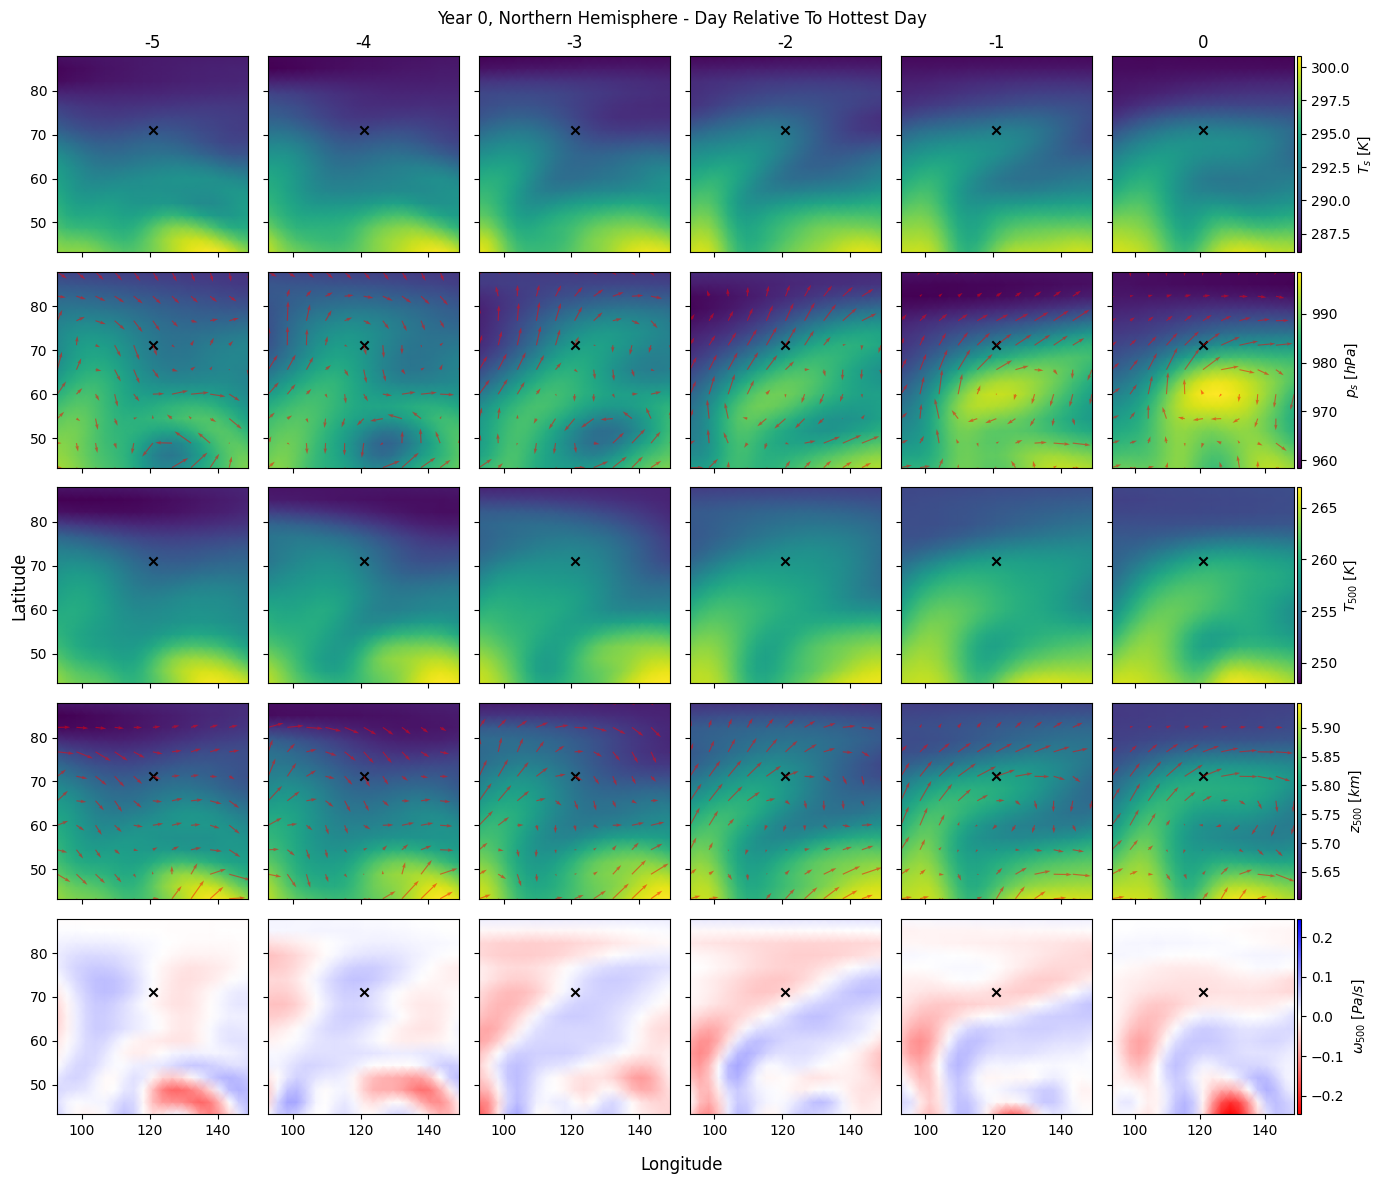

In [286]:
plot_ind = [0, 0]
plot_day = np.asarray([-5,-4,-3,-2,-1,0])
wind_spacing = 2    # larger means less dense arrows
cbar_param = {'aspect': 50, 'pad': 0.015, 'fraction': 0.03}
plot_info = {key: max_info[key][plot_ind[0], plot_ind[1], plot_day+spatial_sz['time']] for key in max_info if
             key not in ['lat', 'lon']}
plot_info['lat'] = max_info['lat'][plot_ind[0], plot_ind[1]]
plot_info['lon'] = max_info['lon'][plot_ind[0], plot_ind[1]]
max_coord = [plot_info['lat'][spatial_sz['lat']], plot_info['lon'][spatial_sz['lon']]]
for key in plot_info:
    if key not in ['lat', 'lon']:
        plot_info[key] = plot_info[key][:, ~np.isnan(plot_info['lat'])]
plot_info['lat'] = plot_info['lat'][~np.isnan(plot_info['lat'])]

var_name = ['temp', 'ps', 'temp', 'height', 'omega']
var_p_ind = [1, -1, 0, 0, 0]
var_label = ['$T_s$ [$K$]', '$p_s$ [$hPa$]', f"$T_{'{'+str(pressure_ft)+'}'}$ [$K$]",
             f"$z_{'{'+str(pressure_ft)+'}'}$ [$km$]", f"$\omega_{'{'+str(pressure_ft)+'}'}$ [$Pa/s$]"]
fig, ax = plt.subplots(5, len(plot_day), figsize=(14,12), sharex=True, sharey=True)
for i in range(len(plot_day)):
    ax[0, i].set_title(plot_day[i])
    for j, var in enumerate(var_name):
        if var == 'omega':
            clims = [-np.nanmax(np.abs(plot_info[var][:, :, :, var_p_ind[j]])),
                     np.nanmax(np.abs(plot_info[var][:, :, :, var_p_ind[j]]))]
            cmap = 'bwr_r'
        else:
            clims = [np.nanmin(plot_info[var][:, :, :, var_p_ind[j]]),
                     np.nanmax(plot_info[var][:, :, :, var_p_ind[j]])]
            cmap = 'viridis'
        im = ax[j, i].pcolormesh(plot_info['lon'], plot_info['lat'], plot_info[var][i, :, :, var_p_ind[j]], shading='gouraud',
                                 vmin=clims[0], vmax=clims[1], cmap=cmap)
        ax[j, i].scatter(max_coord[1], max_coord[0], marker='x', color='k')
        if var in ['ps', 'height']:
            pu, pv = plot_info['ucomp'][i, ::wind_spacing, ::wind_spacing, var_p_ind[j]], \
                plot_info['vcomp'][i, ::wind_spacing, ::wind_spacing, var_p_ind[j]]
            ax[j, i].quiver(plot_info['lon'][::wind_spacing], plot_info['lat'][::wind_spacing], pu, pv, alpha=0.5, color='r')
        if i == len(plot_day)-1:
            plt.colorbar(im, ax=ax[j, -1], label=var_label[j],
                         aspect=cbar_param['aspect'], pad=cbar_param['pad'], fraction=cbar_param['fraction'])
fig.suptitle(f'Year {plot_ind[0]}, ' + ('Northern Hemisphere' if plot_ind[1]==0 else 'Southern Hemisphere') +
             ' - Day Relative To Hottest Day')
fig.supxlabel('Longitude')
fig.supylabel('Latitude')
plt.tight_layout();

In [333]:
# Get summer datasets so you can make above plot relative to the average summer
summer_months_nh = [7, 8, 9]  # July, August, September
summer_months_sh = [1, 2, 3]
ds_summer_av = [annual_time_slice(ds_use, include_months=summer_months_nh).sel(pfull=[pressure_ft, np.inf],
                                                                            method='nearest').mean(dim=['time', 'lon']),
                annual_time_slice(ds_use, include_months=summer_months_sh).sel(pfull=[pressure_ft, np.inf],
                                                                            method='nearest').mean(dim=['time', 'lon'])]
ds_plot_av = ds_summer_av[plot_ind[1]].sel(lat=plot_info['lat']).transpose('lat', 'pfull')
# Add pressure dimension to surface variables to make latter plotting simpler
ds_plot_av['ps'] = ds_plot_av['ps'].expand_dims(dim={"pfull": 2}, axis=-1)/100      # convert to hPa
ds_plot_av['precipitation'] = ds_plot_av['precipitation'].expand_dims(dim={"pfull": 2}, axis=-1)
ds_plot_av['height'] = ds_plot_av['height']/1000    # convert to km

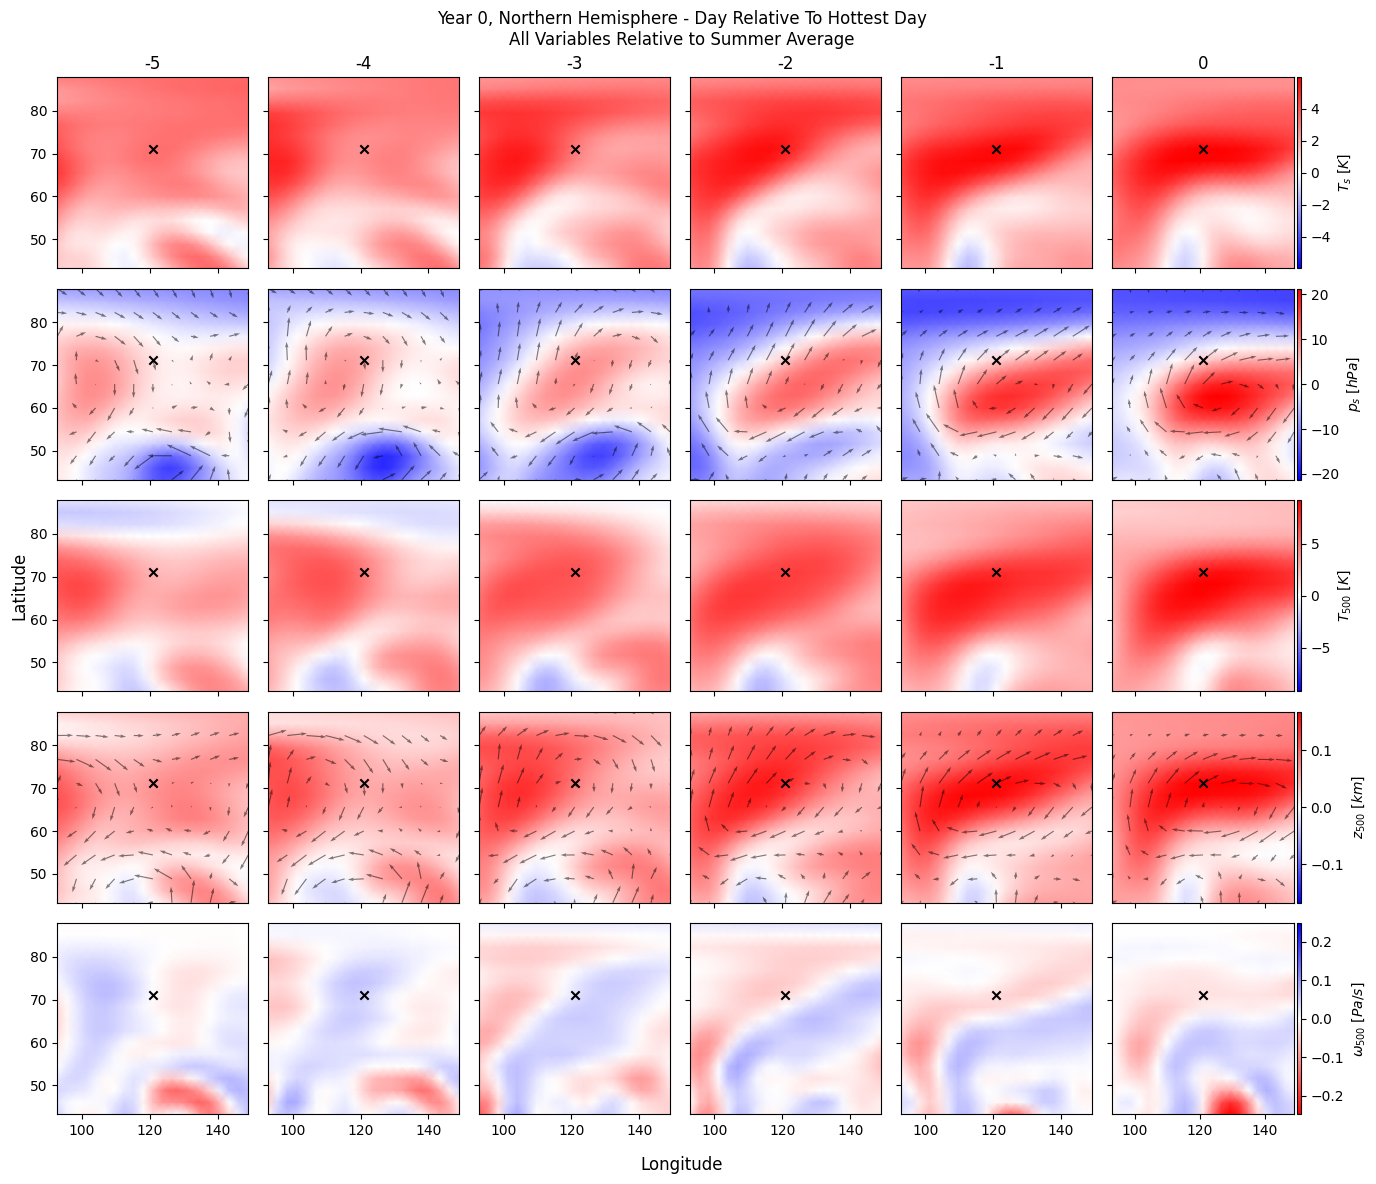

In [340]:
# Plot relative to summer mean
fig, ax = plt.subplots(5, len(plot_day), figsize=(14,12), sharex=True, sharey=True)
for j, var in enumerate(var_name):
    var_diff = plot_info[var] - np.expand_dims(ds_plot_av[var], axis=(0,2))
    clims = [-np.nanmax(np.abs(var_diff[:, :, :, var_p_ind[j]])),
             np.nanmax(np.abs(var_diff[:, :, :, var_p_ind[j]]))]
    for i in range(len(plot_day)):
        ax[0, i].set_title(plot_day[i])
        if var == 'omega':
            cmap = 'bwr_r'
        else:
            cmap = 'bwr'
        im = ax[j, i].pcolormesh(plot_info['lon'], plot_info['lat'], var_diff[i, :, :, var_p_ind[j]], shading='gouraud',
                                 vmin=clims[0], vmax=clims[1], cmap=cmap)
        ax[j, i].scatter(max_coord[1], max_coord[0], marker='x', color='k')
        if var in ['ps', 'height']:
            pu, pv = (plot_info['ucomp']-np.expand_dims(ds_plot_av['ucomp'], axis=(0,2))
                      )[i, ::wind_spacing, ::wind_spacing, var_p_ind[j]], \
                (plot_info['vcomp']-np.expand_dims(ds_plot_av['vcomp'], axis=(0,2))
                 )[i, ::wind_spacing, ::wind_spacing, var_p_ind[j]]
            ax[j, i].quiver(plot_info['lon'][::wind_spacing], plot_info['lat'][::wind_spacing], pu, pv, alpha=0.5, color='k')
        if i == len(plot_day)-1:
            plt.colorbar(im, ax=ax[j, -1], label=var_label[j],
                         aspect=cbar_param['aspect'], pad=cbar_param['pad'], fraction=cbar_param['fraction'])
fig.suptitle(f'Year {plot_ind[0]}, ' + ('Northern Hemisphere' if plot_ind[1]==0 else 'Southern Hemisphere') +
             ' - Day Relative To Hottest Day\nAll Variables Relative to Summer Average')
fig.supxlabel('Longitude')
fig.supylabel('Latitude')
plt.tight_layout();